# Library import

In [35]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from P6_function import *

import re

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

pd.set_option('plotting.backend', 'plotly')
pd.set_option("display.min_rows", 10)
pd.set_option("display.max_columns", 50)
pd.set_option("max_colwidth", 100)

# Data loading

In [36]:
# Load in the dataframe
df = pd.read_csv('01_raw_data/flipkart_com-ecommerce_sample_1050.csv')

# Looking at first 5 rows of the dataset
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                                                                           product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   
1           http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2  http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3  http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt...   
4  http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v...   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                 product_category_tree  \
0  ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   
3  BDSEJT9UQWHDUBH4        2699.0            1299.0   
4  BDSEJTHNGWVGWWQU        2599.0             698.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   
3  d4684dcdc759dd9cdf41504698d737d8.jpg                    False   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...   
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                                                                                product_specifications  
0  {"product_specification"=>[{"k

In [37]:
print("There are {} observations and {} features in this dataset. \n".format(df.shape[0],df.shape[1]))

There are 1050 observations and 15 features in this dataset. 



# Feature cleaning

## product_category_tree

The purpose here is to select at which spet of the category tree we have a relevant information to categorise product. 
The step should be without missing value, suffisantly differente but not too specific

In [38]:
# Visualisation of product category tree structure
df.product_category_tree.head()

0    ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...
4    ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...
Name: product_category_tree, dtype: object

In [39]:
# Creation of a function to clean product cat tree

def clean_cat(text):
    # Remove unneeded character
    text = re.sub(r'\["', repl='', string=text)
    text = re.sub(r'\"]', repl='', string=text)
    text = re.sub(' +', ' ', text)
    # Lower case to avoid spelling differences
    text = text.lower()
    return text
cat = df.product_category_tree.apply(lambda txt : clean_cat(txt))

# Expand the serie into a dataframe
df_cat = pd.DataFrame(cat.str.split(' >>', expand = True))

# Replace None value by NaN
df_cat.replace(to_replace=[None], value=np.nan, inplace=True)
df_cat.head(10)


0                        1                             2  \
0  home furnishing   curtains & accessories                      curtains   
1        baby care         baby bath & skin              baby bath towels   
2        baby care         baby bath & skin              baby bath towels   
3  home furnishing                bed linen                     bedsheets   
4  home furnishing                bed linen                     bedsheets   
5          watches            wrist watches   maserati time wrist watches   
6          watches            wrist watches         camerii wrist watches   
7          watches            wrist watches          t star wrist watches   
8          watches            wrist watches          alfajr wrist watches   
9          watches            wrist watches       tag heuer wrist watches   

                                                      3  \
0   elegance polyester multicolor abstract eyelet do...   
1                             sathiyas baby bath towels   
2                              eurospa baby bath towels   
3                       santosh royal fashion bedsheets   
4                                jaipur print bedsheets   
5                                                   NaN   
6                                                   NaN   
7                                                   NaN   
8                                                   NaN   
9                                                   NaN   

                                                      4    5    6  
0                                                   NaN  NaN  NaN  
1   sathiyas cotton bath towel (3 bath towel, red, y...  NaN  NaN  
2   eurospa cotton terry face towel set (20 piece fa...  NaN  NaN  
3   santosh royal fashion cotton printed king sized ...  NaN  NaN  
4   jaipur print cotton floral king sized double bed...  NaN  NaN  
5                                                   NaN  NaN  NaN  
6                                                   NaN  NaN  NaN  
7                                                   NaN  NaN  NaN  
8                                                   NaN  NaN  NaN  
9                                                   NaN  NaN  NaN

In [40]:
for column in range(0, 7):
    if df_cat.iloc[:, column].nunique() < 20:
        print('Column {}, unique value :\n{}\n'.format(column, df_cat.iloc[:, column].unique()))
    else:
        print('Column {}, {} unique value'.format(column, df_cat.iloc[:, column].nunique()))

Column 0, unique value :
['home furnishing' 'baby care' 'watches' 'home decor & festive needs'
 'kitchen & dining' 'beauty and personal care' 'computers']

Column 1, 62 unique value
Column 2, 239 unique value
Column 3, 348 unique value
Column 4, 295 unique value
Column 5, 116 unique value
Column 6, 57 unique value


In [41]:
filling_factor(df_cat)

column_name  missing_count  filling_factor
0            6            993        5.428571
1            5            923       12.095238
2            4            645       38.571429
3            3            371       64.666667
4            2              3       99.714286
5            0              0      100.000000
6            1              0      100.000000

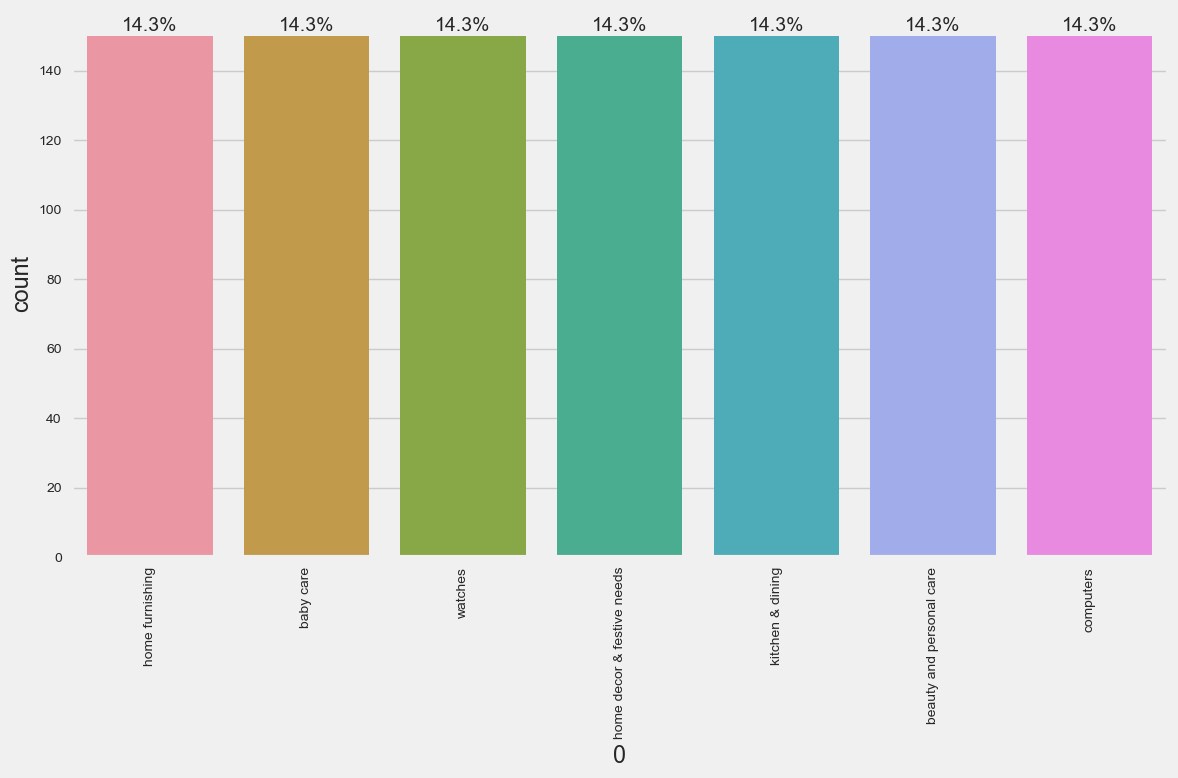

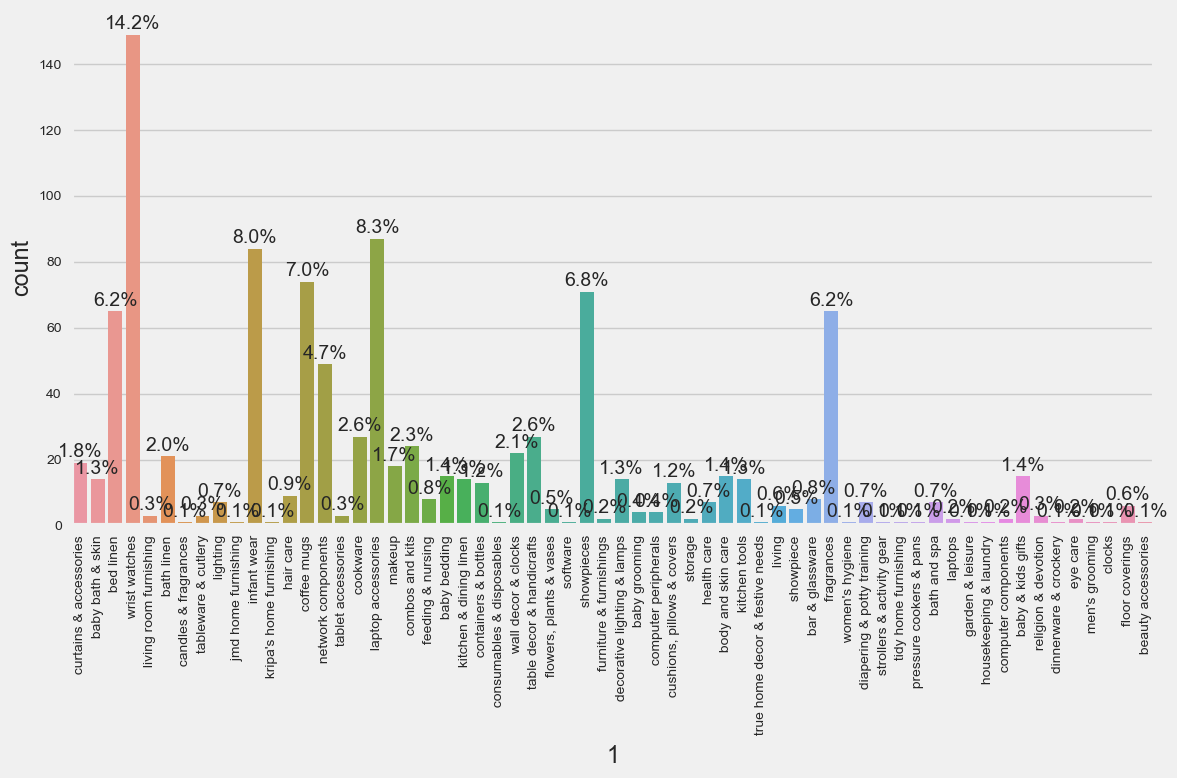

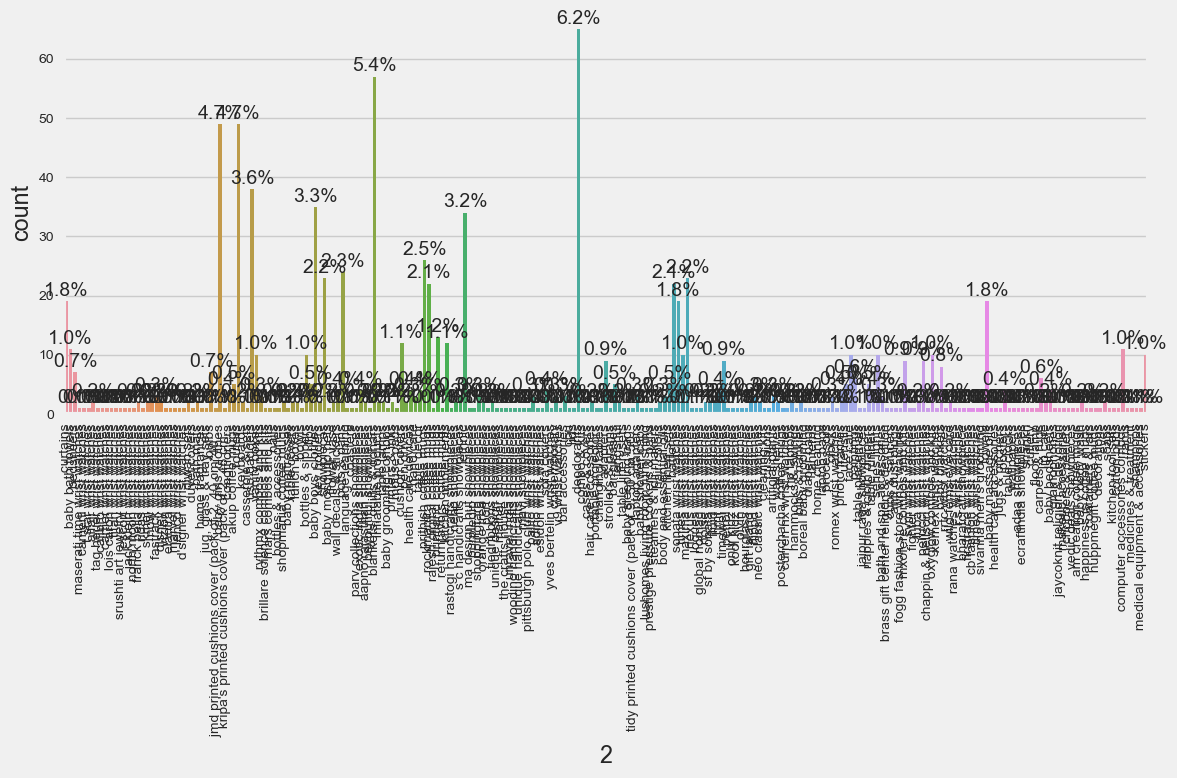

In [42]:
for col in range(0,3):
    barchart_percent(x = col,
    data=df_cat,
    rotation = True)

I will keep the two first tree step

In [43]:
def clean_cat(text):
    # Remove unneeded character
    text = re.sub(r'\["', repl='', string=text)
    text = re.sub(r'\"]', repl='', string=text)
    text = re.sub(' +', ' ', text)
    # Lower case to avoid spelling differences
    text = text.lower()
    #text = text.split(' >> ')
    return text

df.product_category_tree = df.product_category_tree.apply(lambda txt : clean_cat(txt))

In [44]:
df.product_category_tree

0       home furnishing >> curtains & accessories >> curtains >> elegance polyester multicolor abstract ...
1       baby care >> baby bath & skin >> baby bath towels >> sathiyas baby bath towels >> sathiyas cotto...
2       baby care >> baby bath & skin >> baby bath towels >> eurospa baby bath towels >> eurospa cotton ...
3       home furnishing >> bed linen >> bedsheets >> santosh royal fashion bedsheets >> santosh royal fa...
4       home furnishing >> bed linen >> bedsheets >> jaipur print bedsheets >> jaipur print cotton flora...
                                                       ...                                                 
1045                                    baby care >> baby & kids gifts >> stickers >> oren empower stickers
1046                                      baby care >> baby & kids gifts >> stickers >> wallmantra stickers
1047                                        baby care >> baby & kids gifts >> stickers >> uberlyfe stickers
1048                        

In [45]:
# Expand the serie into a dataframe
df[['product_category_1',
    'product_category_2']] = df.product_category_tree.str.split(' >> ', expand = True, n=2).iloc[:, :-1]

df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                                                                           product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   
1           http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2  http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3  http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt...   
4  http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v...   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                 product_category_tree  \
0  home furnishing >> curtains & accessories >> curtains >> elegance polyester multicolor abstract ...   
1  baby care >> baby bath & skin >> baby bath towels >> sathiyas baby bath towels >> sathiyas cotto...   
2  baby care >> baby bath & skin >> baby bath towels >> eurospa baby bath towels >> eurospa cotton ...   
3  home furnishing >> bed linen >> bedsheets >> santosh royal fashion bedsheets >> santosh royal fa...   
4  home furnishing >> bed linen >> bedsheets >> jaipur print bedsheets >> jaipur print cotton flora...   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   
3  BDSEJT9UQWHDUBH4        2699.0            1299.0   
4  BDSEJTHNGWVGWWQU        2599.0             698.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   
3  d4684dcdc759dd9cdf41504698d737d8.jpg                    False   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...   
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                                                                                product_specifications  \
0  {"product_specification"=>[{"

## Keep feature of interest

In [46]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications',
       'product_category_1', 'product_category_2'],
      dtype='object')

In [47]:
features = ['uniq_id',
            'image',
            'description',
            'product_category_1',
            'product_category_2']

df = df[features]
df.head()

uniq_id                                 image  \
0  55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...   
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...   

  product_category_1      product_category_2  
0    home furnishing  curtains & accessories  
1          baby care        baby bath & skin  
2          baby care        baby bath & skin  
3    home furnishing               bed linen  
4    home furnishing               bed linen

# Natural Language Processing

## Cloud of word

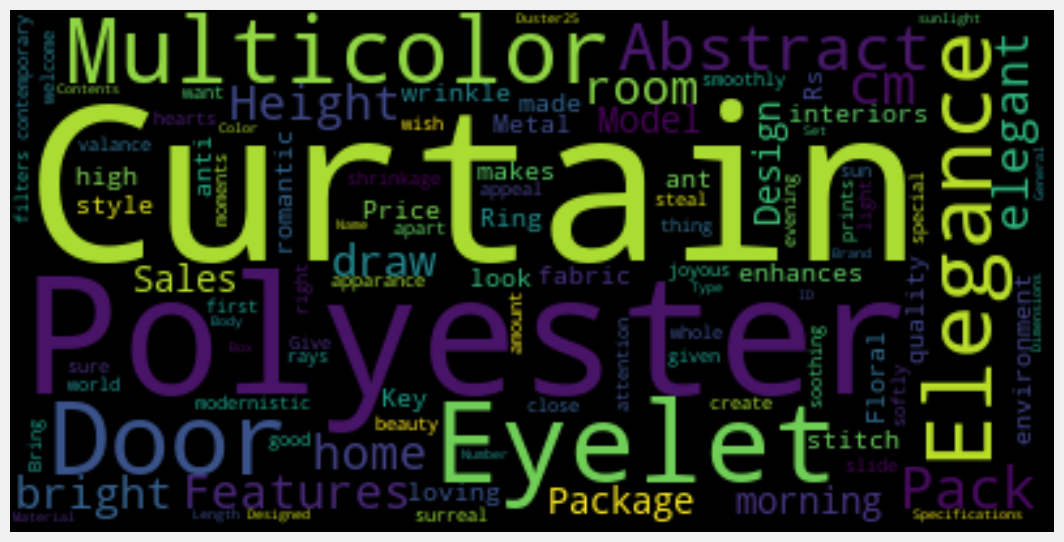

In [14]:
# Start with one description:
text = df.description[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
text = " ".join(review for review in df.description)
print ("There are {} words in the combination of all description.".format(len(text)))

There are 498561 words in the combination of all description.


In [16]:
# We firs will lower all words
text = text.lower()

# using re.sub()
import re
# remove additional space from string 
text = re.sub('-', ' ', text)
text = re.sub(' +', ' ', text)

In [17]:
# We transform the text into a list of words
# by splitting over the space character ' '

word_list = text.split(' ')

# and count the words
word_counts = Counter(word_list)

In [18]:
for w in word_counts.most_common(20):
    print(f'{w[0]}: \t{w[1]} ')

of: 	1747 
for: 	1409 
and: 	1326 
the: 	1317 
in: 	1038 
to: 	1034 
only: 	879 
with: 	836 
on: 	829 
at: 	714 
your: 	656 
a: 	638 
free: 	607 
is: 	592 
rs.: 	584 
buy: 	580 
genuine: 	564 
cash: 	564 
replacement: 	557 
&: 	492 


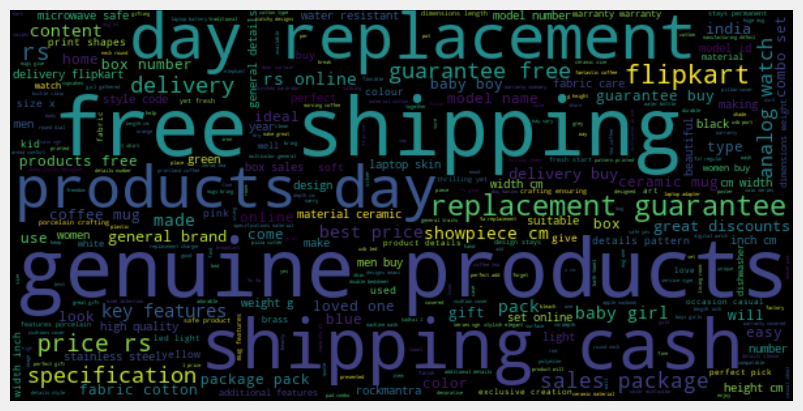

In [19]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Instantiate a new wordcloud.
wordcloud = WordCloud(random_state = 8,
        normalize_plurals = True,
        width = 600, height= 300,
        max_words = 300,
        stopwords = stopwords)
# Apply the wordcloud to the text.
wordcloud.generate(text)

# create a figure
fig, ax = plt.subplots(1,1, figsize = (9,6))
# add interpolation = bilinear to smooth things out
plt.imshow(wordcloud, interpolation='bilinear')
# and remove the axis
plt.axis("off")
plt.show()

In [20]:
print(list(WordCloud().stopwords)[:20])

['was', 'k', 'and', 'but', 'hence', 'then', "mustn't", "didn't", "we're", 'been', "couldn't", 'doing', 'both', 'r', 'his', 'other', "wouldn't", "she'd", 'also', 'were']


## Tokenisation

In [21]:
from nltk.tokenize import WordPunctTokenizer

text = " ".join(review for review in df.description)
tokens = WordPunctTokenizer().tokenize(text)
print(Counter(tokens).most_common(20))

[('.', 5642), (',', 3090), ('-', 1699), ('of', 1663), ('and', 1167), ('the', 1015), (':', 1011), ('to', 983), ('Rs', 911), ('for', 825), ('in', 759), ('Only', 717), ('at', 701), ('with', 688), ('(', 668), (')', 623), ('For', 604), ('your', 600), ('!', 591), ('is', 579)]


In [22]:
from nltk import ngrams
from nltk.tokenize import WordPunctTokenizer

#bigrams 
bigrams = [w for w in ngrams(tokens, n=2)]
print(bigrams[:20], '...')

[('Key', 'Features'), ('Features', 'of'), ('of', 'Elegance'), ('Elegance', 'Polyester'), ('Polyester', 'Multicolor'), ('Multicolor', 'Abstract'), ('Abstract', 'Eyelet'), ('Eyelet', 'Door'), ('Door', 'Curtain'), ('Curtain', 'Floral'), ('Floral', 'Curtain'), ('Curtain', ','), (',', 'Elegance'), ('Elegance', 'Polyester'), ('Polyester', 'Multicolor'), ('Multicolor', 'Abstract'), ('Abstract', 'Eyelet'), ('Eyelet', 'Door'), ('Door', 'Curtain'), ('Curtain', '(')] ...


In [23]:
#trigrams
trigrams = [' '.join(w) for w in ngrams(tokens, n=3)]
print(trigrams[:20], '...')

['Key Features of', 'Features of Elegance', 'of Elegance Polyester', 'Elegance Polyester Multicolor', 'Polyester Multicolor Abstract', 'Multicolor Abstract Eyelet', 'Abstract Eyelet Door', 'Eyelet Door Curtain', 'Door Curtain Floral', 'Curtain Floral Curtain', 'Floral Curtain ,', 'Curtain , Elegance', ', Elegance Polyester', 'Elegance Polyester Multicolor', 'Polyester Multicolor Abstract', 'Multicolor Abstract Eyelet', 'Abstract Eyelet Door', 'Eyelet Door Curtain', 'Door Curtain (', 'Curtain ( 213'] ...


In [24]:
bi_tokens = ['_' .join(w) for w in bigrams]
print(bi_tokens[:20], '...')

['Key_Features', 'Features_of', 'of_Elegance', 'Elegance_Polyester', 'Polyester_Multicolor', 'Multicolor_Abstract', 'Abstract_Eyelet', 'Eyelet_Door', 'Door_Curtain', 'Curtain_Floral', 'Floral_Curtain', 'Curtain_,', ',_Elegance', 'Elegance_Polyester', 'Polyester_Multicolor', 'Multicolor_Abstract', 'Abstract_Eyelet', 'Eyelet_Door', 'Door_Curtain', 'Curtain_('] ...


{'of': 1753, 's': 1750, 'nd': 1525, 'fo': 1442, 'the': 1399, 'n': 1289, 't': 1265, 'to': 1065, 'you': 990, 'only': 888, 'on': 861, 'wth': 842, 'poducts': 635, 'fee': 612, 'dy': 584, 'buy': 581, 'csh': 572, 'delvey': 567, 'genune': 564, 'shppng': 564}


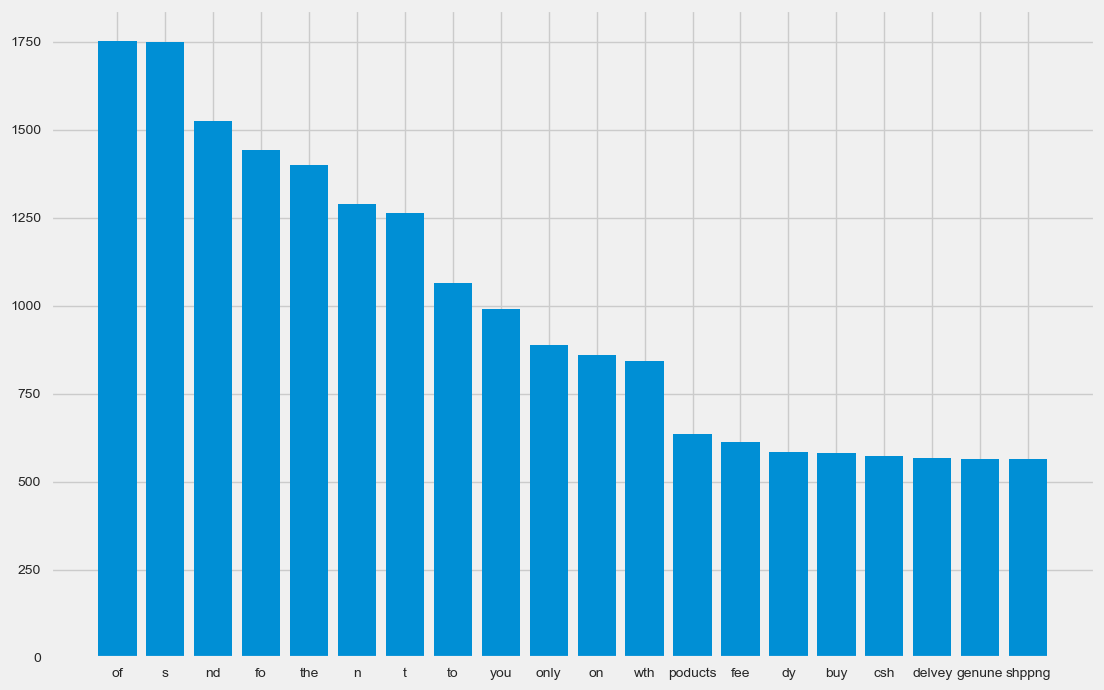

In [25]:
import string
text = " ".join(review for review in df.description).lower()

# Remove punctuation
text_out_punctuation = ''.join([i for i in text if i not in string.punctuation])

#Remove digits
text_out_digits = ''.join([i for i in text_out_punctuation if i not in string.digits])

#Remove stopwords
stopwords = set(STOPWORDS)
# use a python list comprehension to remove the stopwords from words_list
text_without_stopwords = ''.join([ i for i in text_out_digits if i not in stopwords])
text_clean = text_without_stopwords

#Tokenisation
tokens = WordPunctTokenizer().tokenize(text_clean)
w = dict(Counter(tokens).most_common(20))
print(w)
plt.bar(w.keys(), w.values())
plt.style.context('fivethirtyeight')

In [26]:
print ("There are {} words in the combination of all description.".format(len(text_clean)))

There are 378672 words in the combination of all description.


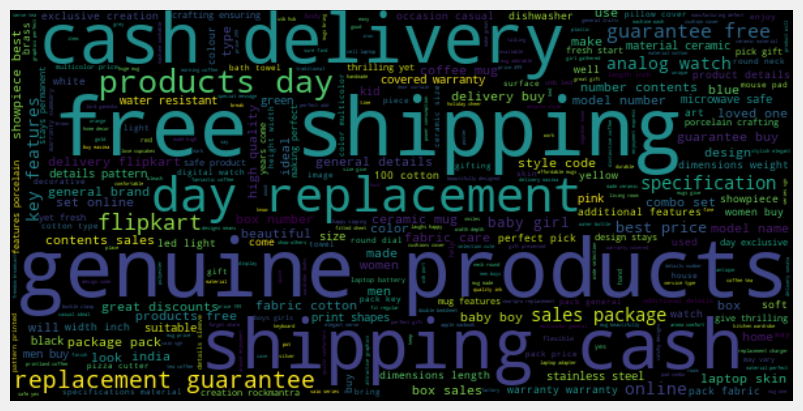

In [27]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Instantiate a new wordcloud.
wordcloud = WordCloud(random_state=8,
                      collocations=True,
                      normalize_plurals = True,
                      include_numbers=True,
                      min_word_length=3,
                      width = 600, height= 300,
                      max_words = 300,
                      stopwords = stopwords)
# Apply the wordcloud to the text.
wordcloud.generate(text)

# create a figure
fig, ax = plt.subplots(1,1, figsize = (9,6))
# add interpolation = bilinear to smooth things out
plt.imshow(wordcloud, interpolation='bilinear')
# and remove the axis
plt.axis("off")
plt.show()

### Tokenisation and stemmisation

In [28]:
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


# Get the text and remove ponctuation and digits
text = " ".join(review for review in df.description).lower()
text_out_punctuation = ''.join([i for i in text if i not in string.punctuation])
text_out_digits = ''.join([i for i in text_out_punctuation if i not in string.digits])
text_clean = text_out_digits

# Tokenize and remove stopwords
tokens = WordPunctTokenizer().tokenize(text_clean)
tokens = [tk for tk in tokens if tk not in stopwords.words('english')]

#for token in tokens:
 #   token.replace(" ", "")

# Initiate stemmer 
ps = PorterStemmer()

# and stem 
stems = [ps.stem(tk) for tk in tokens]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/franck/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenisation and Lemmanisation

In [29]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp(text_clean)

for token in doc[:20]:
    print(token)

key
features
of
elegance
polyester
multicolor
abstract
eyelet
door
curtain
floral
curtainelegance
polyester
multicolor
abstract
eyelet
door
curtain
 
cm


In [30]:
print(f"{'Token':10}\t Lemma")
print(f"{'-------':10}\t ------ ")
for token in doc[:20]: 
    print(f'{token.text:10}\t {token.lemma_} ')

Token     	 Lemma
-------   	 ------ 
key       	 key 
features  	 feature 
of        	 of 
elegance  	 elegance 
polyester 	 polyester 
multicolor	 multicolor 
abstract  	 abstract 
eyelet    	 eyelet 
door      	 door 
curtain   	 curtain 
floral    	 floral 
curtainelegance	 curtainelegance 
polyester 	 polyester 
multicolor	 multicolor 
abstract  	 abstract 
eyelet    	 eyelet 
door      	 door 
curtain   	 curtain 
          	   
cm        	 cm 


In [31]:
print(f"token \t\tspace? \tpunct?\tupper?\tdigit?")
token, token.is_space, token.is_punct, token.is_upper, token.is_digit
token_count = []
token, token.is_space, token.is_punct, token.is_upper, token.is_digit
for token in doc: 
    token_count.append([token.is_space, token.is_punct, token.is_upper, token.is_digit])
    #print(f"{str(token):10} \t{token.is_space} \t{token.is_punct} \t{token.is_upper} \t{token.is_digit}")

token 		space? 	punct?	upper?	digit?


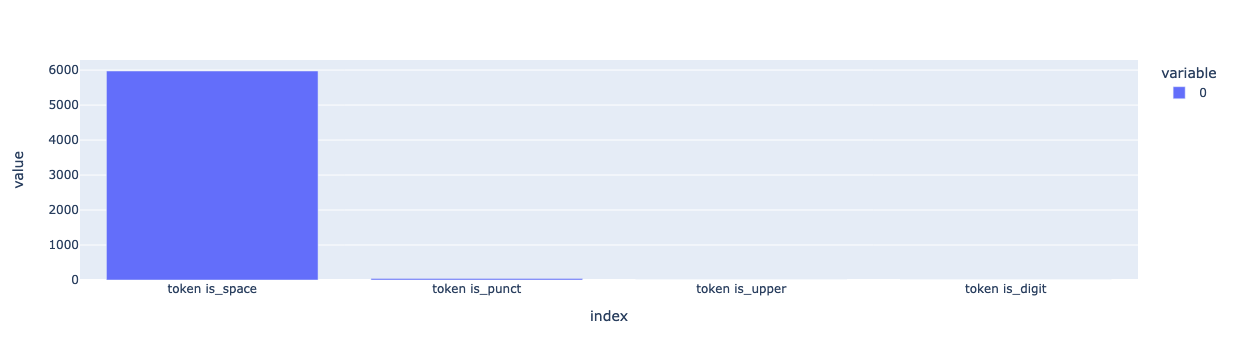

In [32]:
df_count_token = pd.DataFrame(token_count, columns=['token is_space',
                                            'token is_punct',
                                            'token is_upper',
                                            'token is_digit']).sum()
df_count_token.plot(kind='bar')

## Vectorisation - Bag-of-words (BOW)

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df.description)
X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [34]:
# Create a function to lemmatize each description
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
    text = text.lower()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct or token.is_digit)] 
    return ' '.join(tokens)

In [35]:
df['processed_description'] = df.description.apply(lambda txt : lemmatize(txt))

In [36]:
df['processed_description'].head()

0    key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance p...
1    specification sathiyas cotton bath towel bath towel red yellow blue bath towel feature machine w...
2    key feature eurospa cotton terry face towel set size small height inch gsm 360,eurospa cotton te...
3    key feature santosh royal fashion cotton print king size double bedsheet royal bedsheet perfact ...
4    key feature jaipur print cotton floral king size double bedsheet cotton jaipur print cotton flor...
Name: processed_description, dtype: object

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=.5,
                     min_df=5)
X = cv.fit_transform(df['processed_description'])
X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 2, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

## Word classification

In [38]:
# Definition of target and feature variable

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=.5,
                     min_df=5)
X = cv.fit_transform(df['processed_description'])

y = df['product_category_1']

In [39]:
# Train, Test split
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=5)

print(X_train.shape)
print(y_train.shape)

(840, 922)
(840,)


In [40]:
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 1. Declare the model
clf = MultinomialNB()

# 2. Train the model
clf.fit(X_train, y_train)

# 3. Make predictions 
y_pred = clf.predict(X_test)

# 4. score
print("Accuracy: ",accuracy_score(y_test, y_pred))

Accuracy:  0.8571428571428571


# Computer Vision

## ORB

### Import DataSet

In [41]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Image label creation

In [81]:
from sklearn import preprocessing

list_labels = ['home furnishing', 'baby care', 'watches',
       'home decor & festive needs', 'kitchen & dining',
       'beauty and personal care', 'computers']

df_image = df.loc[:, ['image', 'product_category_1']]
le = preprocessing.LabelEncoder()
df_image['label'] = le.fit_transform(df_image['product_category_1'])
df_image

image product_category_1  label
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg    home furnishing      4
1     7b72c92c2f6c40268628ec5f14c6d590.jpg          baby care      0
2     64d5d4a258243731dc7bbb1eef49ad74.jpg          baby care      0
3     d4684dcdc759dd9cdf41504698d737d8.jpg    home furnishing      4
4     6325b6870c54cd47be6ebfbffa620ec7.jpg    home furnishing      4
...                                    ...                ...    ...
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg          baby care      0
1046  fd6cbcc22efb6b761bd564c28928483c.jpg          baby care      0
1047  5912e037d12774bb73a2048f35a00009.jpg          baby care      0
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg          baby care      0
1049  f2f027ad6a6df617c9f125173da71e44.jpg          baby care      0

[1050 rows x 3 columns]

In [43]:
df_image.groupby('label').count()

image  product_category_1
label                           
0        150                 150
1        150                 150
2        150                 150
3        150                 150
4        150                 150
5        150                 150
6        150                 150

### Show image exemple

home furnishing


NameError: name 'path' is not defined

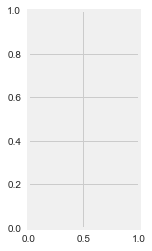

In [44]:
from matplotlib.image import imread

def list_fct(name):
    list_img_name = [df_image['image'][i] for i in range(len(df_image)) if df_image['product_category_1'][i]==name]
    return list_img_name

list_home_furnishing = list_fct('home furnishing')
list_baby_care = list_fct('baby care')
list_watches = list_fct('watches')
list_home_decor = list_fct('home decor & festive needs')
list_kitchen_dining = list_fct('kitchen & dining')
list_beauty_personal_care = list_fct('beauty and personal care')
list_computers = list_fct('computers')

for name in list_labels:
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i + 10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

### Image descripter ORB


* The picture contain 500 descriptors
* Each descriptor is a vector of 32

In [ ]:
import cv2

orb = cv2.ORB_create(500)
image = cv2.imread(path+list_img[819], 0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = orb.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.show()
print("Descriptor : ", des.shape)
print()
print(des)


## Creation of descriptors per image

* For each image we equalize and convert in gray
* Creation of a list of descriptors per mage ("orb_keypoints_by_img") which will be use to realise image histogramme
* Creation of liste of descriptros for all images ('orb_keypoints_all') which will be used to create desriptors clusters

In [ ]:
# identification of key points and associated descriptors
import time, cv2
orb_keypoints = []
temps1 = time.time()
orb = cv2.ORB_create(500)

for image_num in range(len(list_img)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_img[image_num], 0) # convert in gray
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints, dtype="object")

orb_keypoints_all  = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nomber of descriptoss : ", orb_keypoints_all.shape)

duration1 = time.time() - temps1
print("Treatment time for ORB descriptor : ", "%15.2f" % duration1, "seconds")

### Creation of clusters of descriptors
* Use of MiniBatchKMeans to obtain a reasonnable treatment time

In [ ]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Estimates number of clusters : ", k)
print("Creation of",k, "descriptors' clusters ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("kmeans treatment time: ", "%15.2f" % duration1, "seconds")

### Creation of images features 
* For each image: 
    - predict the number of cluster for each descriptors
    - creation of histogram = count of each clusters number for each image descriptors

In [ ]:
# Creation of histograms (features)
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0 : print("problem histogram image: ", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(orb_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Histogram creation time : ", "%15.2f" % duration1, "seconds")


### Dimension reduction

#### PCA dimension reduction

* PCA dimension reduction allows to create features decorreleted et decrease dimension, still with a high explained variance (99%)
* We have a better dimension reduction with T-SNE and a decrease in treatment time

In [ ]:
from sklearn import manifold, decomposition

print("Dataset dimensions before PCA: ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dataset dimensions after PCA: ", feat_pca.shape)

Dimension reduction into 2D to visualize data 

In [ ]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2,
                     perplexity=30, 
                     n_iter=2000,
                     init='random',
                     random_state=6)

X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2],
                       columns=['tsne1', 'tsne2'])

df_tsne['label'] = df_image['product_category_1']
print(df_tsne.shape)

### Viusal analysis: T-SNE with image category

   * Categroies seems not separate

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue="label",
                data=df_tsne,
                legend="brief",
                palette=sns.color_palette('tab10', n_colors=7),
                s=50,
                alpha=0.6)

plt.title('TSNE with true labels')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend() 

plt.show()

### Measures analysis: Similarity between category and clusters
#### Clusters creation with T-SNE

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7,
                     random_state=123)
cls.fit(X_tsne)

df_tsne['cluster'] = cls.labels_
print(df_tsne.shape)

### Show clusters a calculated ARI 
* ARI score is very low 0.0025

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue='cluster',
                palette=sns.color_palette('tab10', n_colors=7),
                s=50,
                alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les clusters')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend() 

plt.show()

labels = df_image['label']
print("ARI: ", metrics.adjusted_rand_score(df_image['label'], cls.labels_))

### Cluster Analysis
* Confusion matrix should be transform to have in column the same order for cluster as for line
* We use argmax method to transform tje confusion matrix to match cluster labels

In [ ]:
df_tsne.groupby("cluster").count()['label']

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    #corresp = np.argmax(conf_mat, axis=0)
    corresp = [2, 3, 0, 6, 5, 1, 4]
    print ("Cluster correspondance : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Cours OC

In [57]:
import PIL
from PIL import Image

# Charger l'image
img = Image.open("simba.png") 

# Afficher l'image chargée
img.show()

In [46]:
# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 250 px, hauteur : 263 px


In [47]:
# Afficher son mode de quantification
print("Format des pixels : {}".format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print("Valeur du pixel situé en (20,100) : {}".format(px_value))

Format des pixels : L
Valeur du pixel situé en (20,100) : 196


In [49]:
import numpy as np

# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)
print(mat)

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat.shape))

[[247 245 245 ... 224 228 228]
 [246 244 243 ... 228 230 230]
 [244 242 240 ... 230 231 231]
 ...
 [183 169 169 ... 108  95 102]
 [170 160 171 ...  81  95  99]
 [150 155 174 ... 133 115 111]]
Taille de la matrice de pixels : (263, 250)


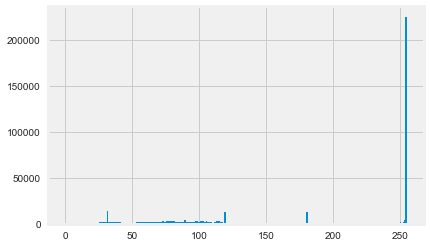

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Charger l'image comme matrice de pixels
img = np.array(Image.open('simba_sombre.png'))

# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

In [58]:
# Charger l'image sous forme d'une matrice de pixels
img = np.array(Image.open('simba.png'))

# Générer le bruit gaussien de moyenne nulle et d'écart-type 7 (variance 49)
noise = np.random.normal(0, 7, img.shape)

# Créer l'image bruitée et l'afficher
noisy_img = Image.fromarray(img + noise).convert('L')
noisy_img.show()

In [59]:
from PIL import ImageFilter

# Appliquer le lissage par moyennage (fenêtre de taille 9) et afficher le résultat
noisy_img.filter(ImageFilter.BoxBlur(1)).show()

# Transfert Learning VGG16

In [55]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

my_VGG16 = Sequential()  # Création d'un réseau de neurones vide 

# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_VGG16.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))

# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_VGG16.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

# Ajout de la première couche de pooling
my_VGG16.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

In [56]:
from keras.layers import Flatten, Dense

my_VGG16.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la deuxième couche fully-connected, suivie d'une couche ReLU
my_VGG16.add(Dense(4096, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_VGG16.add(Dense(7, activation='softmax'))

In [61]:
import keras

In [72]:
#from keras.optimizers import Adam
#opt = Adam(lr=0.001)
my_VGG16.compile(loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [76]:
my_VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 802816)            0         
_________________________________________________________________
dense (Dense)                (None, 4096)              3288338432
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 2

In [78]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="01_raw_data/Images/",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="01_raw_data/Images/", target_size=(224,224))

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


In [80]:
df

uniq_id                                 image  \
0     55b85ea15a1536d46b7190ad6fff8ce7  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8  d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7  6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                ...                                   ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44  f2f027ad6a6df617c9f125173da71e44.jpg   

                                                                                              description  \
0     Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1     Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2     Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   
3     Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...   
4     Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...   
...                                                                                                   ...   
1045  Oren Empower Extra Large Self Adhesive Sticker (Pack of 2)\r\n                         Price: Rs...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack of 1)\r\n                         Price: Rs. 1,896\...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker for Rs.1449 online. Uberly...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker for Rs.1333 online. Wallmantra Medium Vinyl Sticker ...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 online. Uberlyfe Large Vinyl Sticker at best prices ...   

     product_category_1      product_category_2  
0       home furnishing  curtains & accessories  
1             baby care        baby bath & skin  
2             baby care        baby bath & skin  
3       home furnishing               bed linen  
4       home furnishing               bed linen  
...                 ...                     ...  
1045          baby care       baby & kids gifts  
1046          baby care       baby & kids gifts  
1047          baby care       baby & kids gifts  
1048          baby care       baby & kids gifts  
1049          baby care       baby & kids gifts  

[1050 rows x 5 columns]

In [88]:
im_list = []

for im in glob.glob('01_raw_data/Images/*'):
    im = cv2.imread(im)
    im = cv2.resize(im,(224,224))
    im_list.append(im)

In [99]:
np.array(im_list).shape

(1050, 224, 224, 3)

In [97]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = my_VGG16.fit(steps_per_epoch=100, y=df_image['label'], x=np.array(im_list), validation_steps=10,epochs=100)

Epoch 1/100


ValueError: in user code:

    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/franck/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 7) are incompatible


In [64]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

img = load_img('simba.png', target_size=(224, 224))  # Charger l'image
img = img_to_array(img)  # Convertir en tableau numpy
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  # Créer la collection d'images (un seul échantillon)
img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16

In [68]:
y = model.predict(img)  # Prédir la classe de l'image (parmi les 1000 classes d'ImageNet)

In [69]:
from keras.applications.vgg16 import decode_predictions

# Afficher les 3 classes les plus probables
print('Top 3 :', decode_predictions(y, top=3)[0])

49152/35363 [=========================================] - 0s 0us/step
Top 3 : [('n03404251', 'fur_coat', 0.12521926), ('n04367480', 'swab', 0.062493153), ('n02490219', 'marmoset', 0.038646445)]


In [10]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras import Model
# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [109]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

model = InceptionV3(weights='imagenet', include_top=False)

87924736/87910968 [==============================] - 2s 0us/step


In [19]:
import numpy as np
def extract_vector(path):
    feature_list = []

    for im in glob.glob(path):

        im = cv2.imread(im)
        im = cv2.resize(im,(224,224))
        img = preprocess_input(np.expand_dims(im.copy(), axis=0))
        feature = model.predict(img)
        feature_np = np.array(feature)
        feature_list.append(feature_np.flatten())

    return np.array(feature_list)

In [49]:
import glob
import cv2

features = extract_vector('01_raw_data/Images/*')



Dataset dimensions before PCA:  (1050, 25088)
Dataset dimensions after PCA:  (1050, 939)


/Users/franck/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


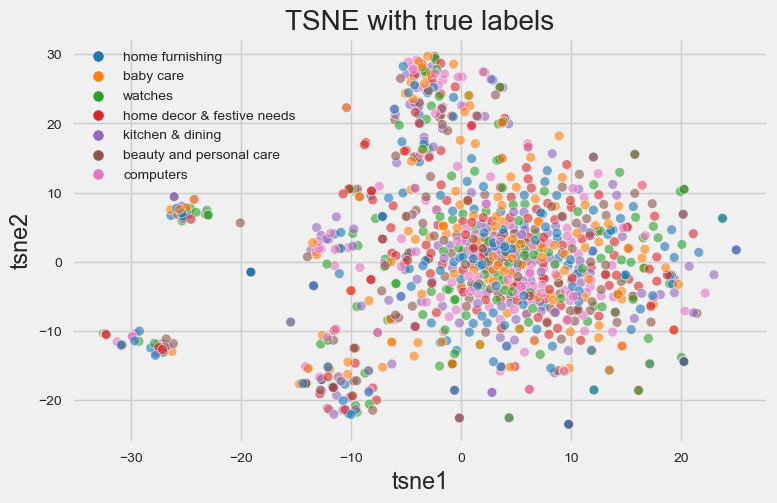

In [51]:
from sklearn import manifold, decomposition
import pandas as pd

print("Dataset dimensions before PCA: ", features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features)
print("Dataset dimensions after PCA: ", feat_pca.shape)


from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2,
                     perplexity=30, 
                     n_iter=2000,
                     init='random',
                     random_state=6)

X_tsne = tsne.fit_transform(features)

df_tsne = pd.DataFrame(X_tsne[:, 0:2],
                       columns=['tsne1', 'tsne2'])

df_tsne['label'] = df['product_category_1']
print(df_tsne.shape)

plt.figure(figsize=(8, 5))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue="label",
                data=df_tsne,
                legend="brief",
                palette=sns.color_palette('tab10', n_colors=7),
                s=50,
                alpha=0.6)

plt.title('TSNE with true labels')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend() 

plt.show()

In [52]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7,
                     random_state=123)
cls.fit(features)

df_tsne['cluster'] = cls.labels_
print(df_tsne.shape)

(1050, 4)


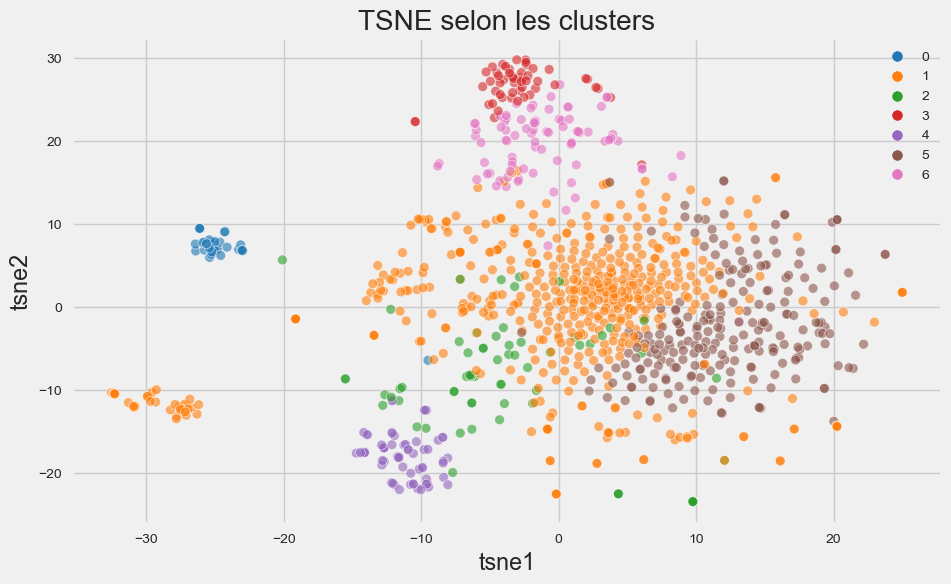

KeyError: 'label'

In [54]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="tsne1",
                y="tsne2",
                hue='cluster',
                palette=sns.color_palette('tab10', n_colors=7),
                s=50,
                alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les clusters')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend() 

plt.show()

labels = df['label']
print("ARI: ", metrics.adjusted_rand_score(df_image['label'], cls.labels_))